
# K‑Means Clustering — Visual Guide & Diagnostics

This notebook builds a few 2D synthetic datasets and visualizes **K‑Means** behavior under different choices:
- **Elbow curve** (inertia vs K) and **silhouette scores**
- **Initialization**: `k-means++` vs `random`, and the role of `n_init`
- **Stability across seeds**
- **Decision regions** (nearest-center Voronoi view) and **cluster centers**
- **Effect of feature scaling** (raw vs standardized)
- **Anisotropic blobs** and **non-globular shapes** (limits of K‑Means)
- **PCA projection** (optional) for higher-dimensional features

Each figure is rendered on its own plot (no subplots) for clean copying into slides.


In [17]:

import numpy as np
import matplotlib.pyplot as plt, warnings
import pandas as pd

from sklearn.datasets import make_blobs, make_moons, make_classification
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

np.random.seed(42)
warnings.filterwarnings("ignore")

def plot_clusters(X, labels, centers=None, title=""):
    plt.figure(figsize=(6,5))
    plt.scatter(X[:,0], X[:,1], c=labels, s=14, alpha=0.8)
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], s=160, marker="X")
    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.tight_layout(); plt.show()

def decision_regions(km, X, title=""):
    x_min, x_max = X[:,0].min()-1.0, X[:,0].max()+1.0
    y_min, y_max = X[:,1].min()-1.0, X[:,1].max()+1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 600),
                         np.linspace(y_min, y_max, 600))
    XY = np.c_[xx.ravel(), yy.ravel()]
    Z = km.predict(XY).reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.15)
    plt.scatter(X[:,0], X[:,1], c=km.labels_, s=14, alpha=0.85)
    plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=160, marker="X")
    plt.title(title + f"\nInertia={km.inertia_:.1f}, Silhouette={silhouette_score(X, km.labels_):.3f}")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.tight_layout(); plt.show()

def silhouette_diagram(X, labels, title=""):
    s = silhouette_samples(X, labels)
    k = len(np.unique(labels))
    plt.figure(figsize=(6,5))
    y_lower = 10
    for i in range(k):
        si = s[labels == i]
        si.sort()
        y_upper = y_lower + len(si)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, si, alpha=0.6)
        y_lower = y_upper + 10
    plt.axvline(np.mean(s), linestyle="--")
    plt.title(title)
    print(title + f"\nMean silhouette = {np.mean(s):.3f}")
    plt.xlabel("silhouette coefficient"); plt.ylabel("samples (grouped by cluster)")
    plt.tight_layout(); plt.show()


## 1) Blobs dataset (spherical clusters)

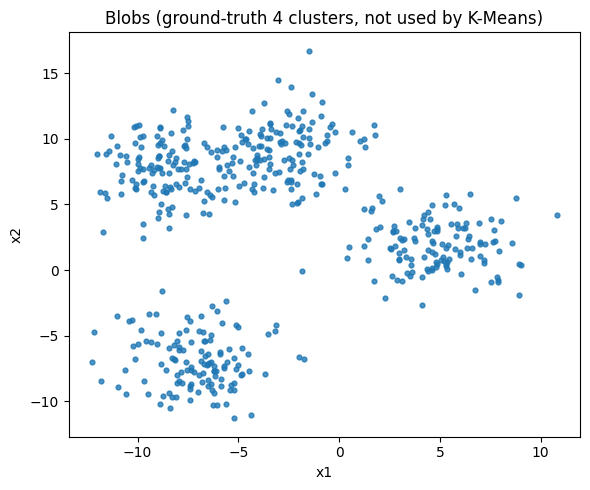

In [18]:

from sklearn.datasets import make_blobs

X_blobs, y_true = make_blobs(n_samples=500, centers=4, cluster_std=2, random_state=42)
plt.figure(figsize=(6,5)); plt.scatter(X_blobs[:,0], X_blobs[:,1], s=12, alpha=0.8)
plt.title("Blobs (ground-truth 4 clusters, not used by K-Means)")
plt.xlabel("x1"); plt.ylabel("x2"); plt.tight_layout(); plt.show()


## 2) Elbow curve (inertia vs K)

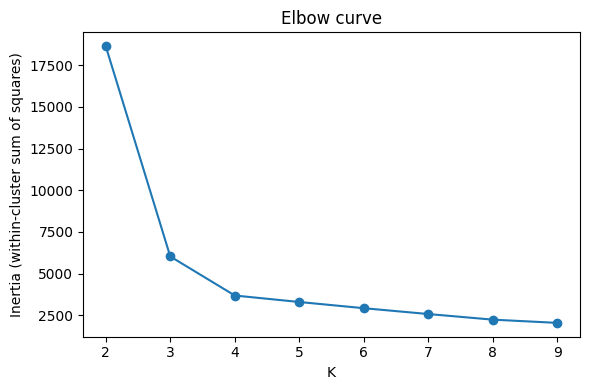

In [19]:

inertias = []
Ks = list(range(2, 10))
for k in Ks:
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    km.fit(X_blobs)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker="o")
plt.xlabel("K"); plt.ylabel("Inertia (within-cluster sum of squares)")
plt.title("Elbow curve")
plt.tight_layout(); plt.show()


## 3) Silhouette score vs K

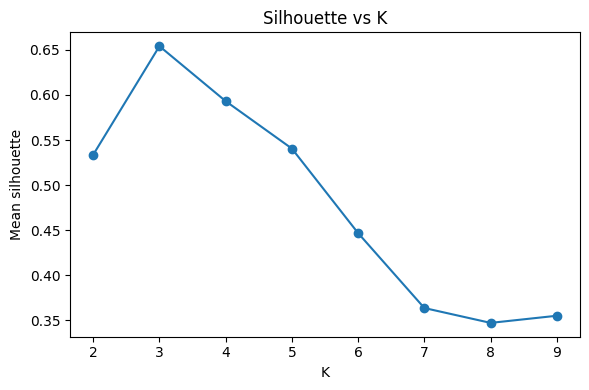

In [20]:

sils = []
for k in Ks:
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    labels = km.fit_predict(X_blobs)
    sils.append(silhouette_score(X_blobs, labels))

plt.figure(figsize=(6,4))
plt.plot(Ks, sils, marker="o")
plt.xlabel("K"); plt.ylabel("Mean silhouette")
plt.title("Silhouette vs K")
plt.tight_layout(); plt.show()


## 4) K=4 decision regions and silhouette diagram

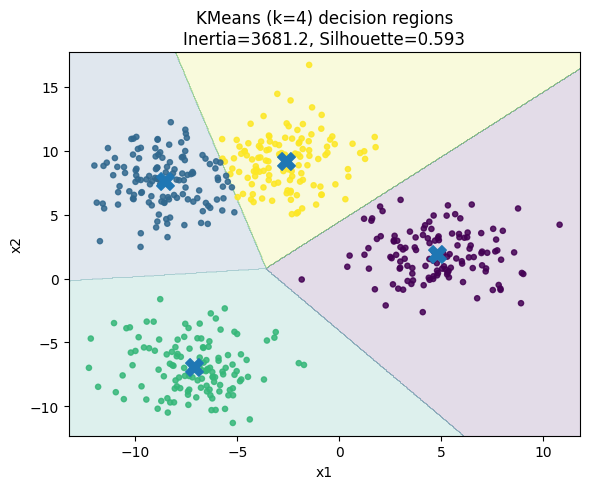

Silhouette diagram (k=4)
Mean silhouette = 0.593


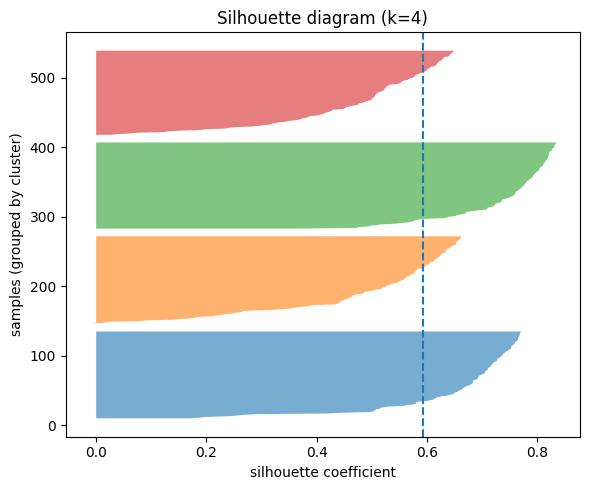

In [21]:

km4 = KMeans(n_clusters=4, init="k-means++", n_init=20, random_state=42).fit(X_blobs)
decision_regions(km4, X_blobs, "KMeans (k=4) decision regions")
silhouette_diagram(X_blobs, km4.labels_, "Silhouette diagram (k=4)")


## 5) Initialization & restarts (n_init)

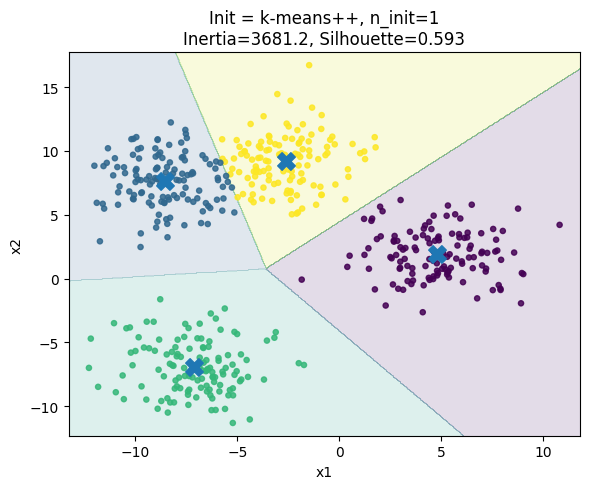

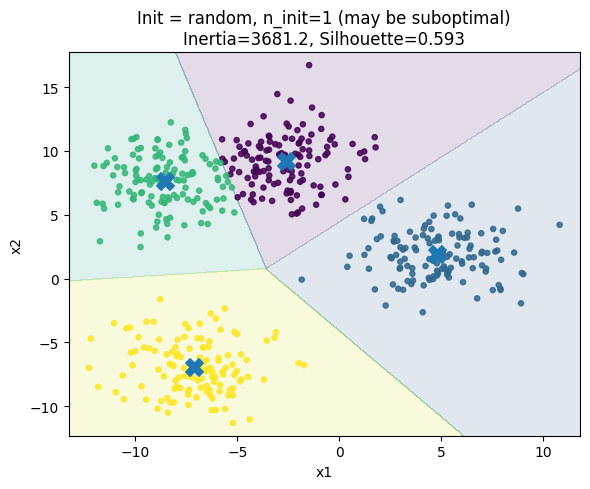

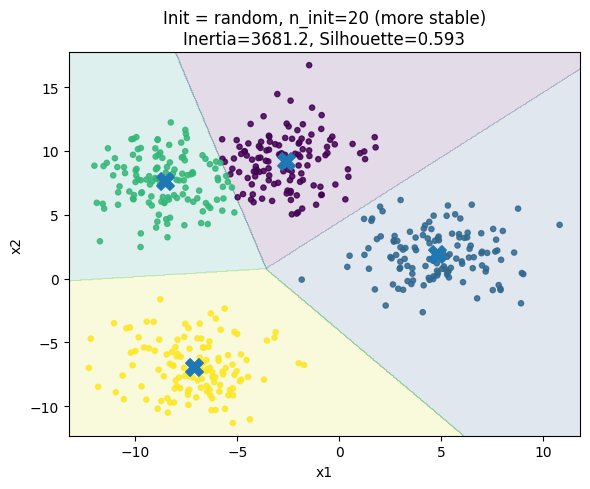

In [22]:

km_pp = KMeans(n_clusters=4, init="k-means++", n_init=1, random_state=1).fit(X_blobs)
decision_regions(km_pp, X_blobs, "Init = k-means++, n_init=1")

km_rand_1 = KMeans(n_clusters=4, init="random", n_init=1, random_state=1).fit(X_blobs)
decision_regions(km_rand_1, X_blobs, "Init = random, n_init=1 (may be suboptimal)")

km_rand_20 = KMeans(n_clusters=4, init="random", n_init=20, random_state=1).fit(X_blobs)
decision_regions(km_rand_20, X_blobs, "Init = random, n_init=20 (more stable)")


## 6) Stability across seeds (same K, multiple runs)

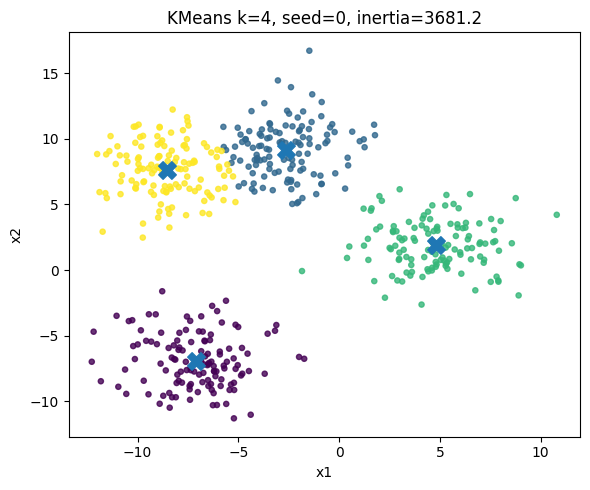

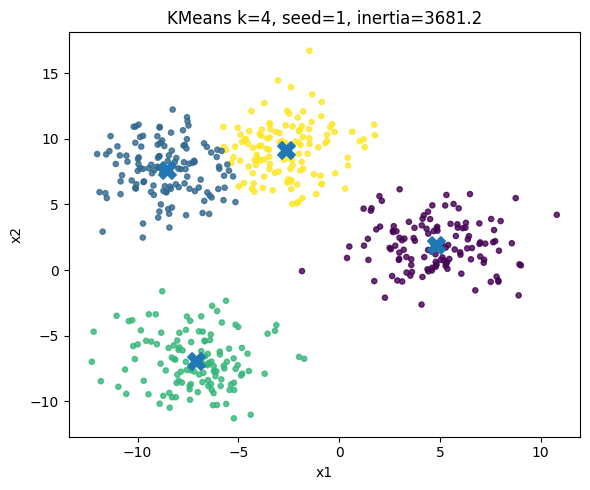

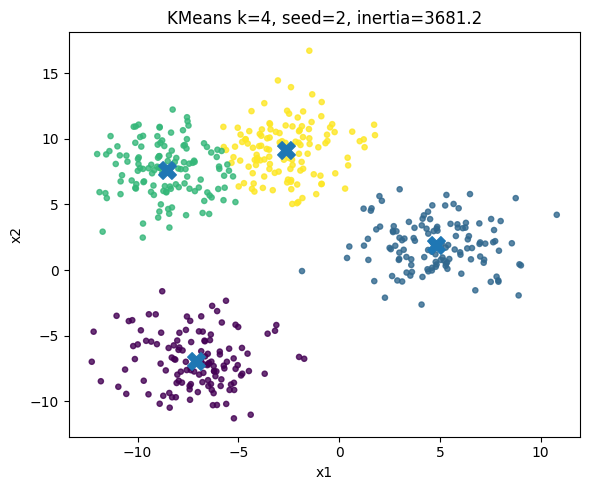

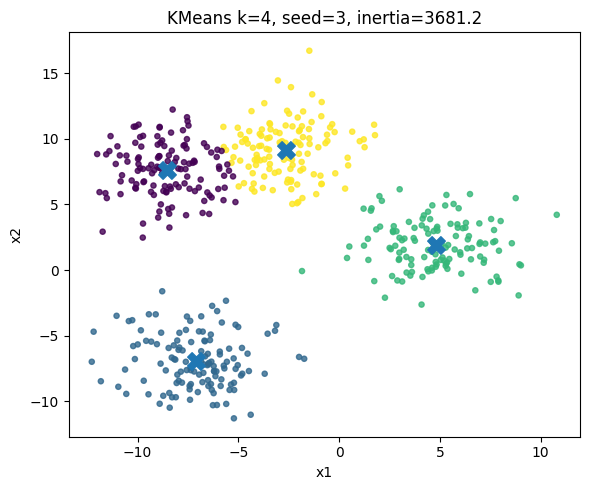

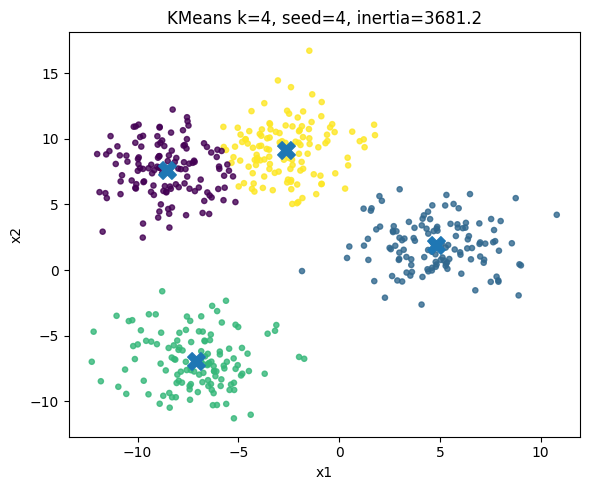

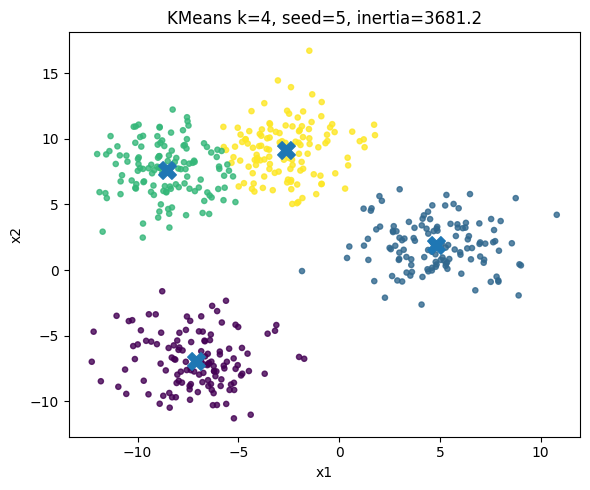

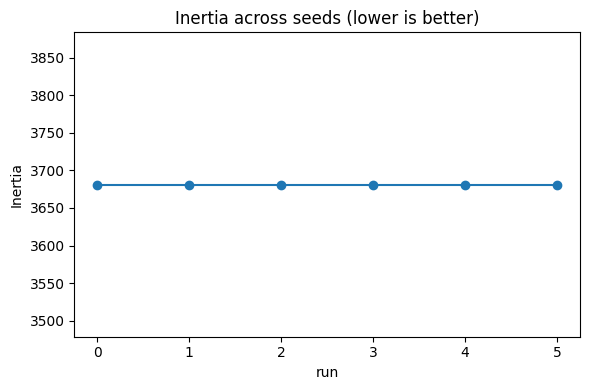

In [23]:

inerts = []
for seed in [0, 1, 2, 3, 4, 5]:
    km = KMeans(n_clusters=4, init="k-means++", n_init=10, random_state=seed).fit(X_blobs)
    inerts.append(km.inertia_)
    plot_clusters(X_blobs, km.labels_, km.cluster_centers_, f"KMeans k=4, seed={seed}, inertia={km.inertia_:.1f}")

plt.figure(figsize=(6,4))
plt.plot(range(len(inerts)), inerts, marker="o")
plt.xlabel("run"); plt.ylabel("Inertia")
plt.title("Inertia across seeds (lower is better)")
plt.tight_layout(); plt.show()


## 7) Effect of feature scaling

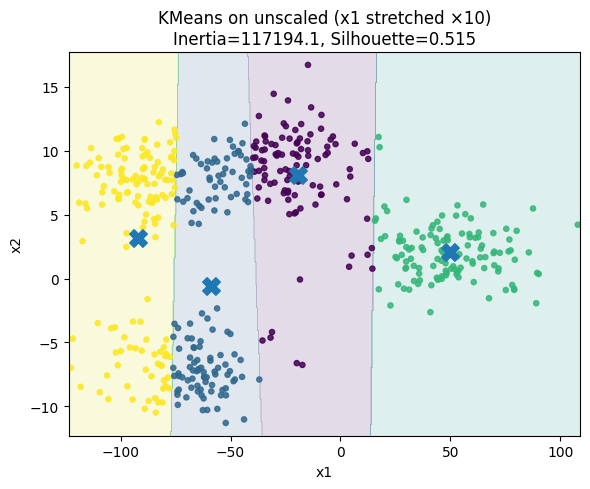

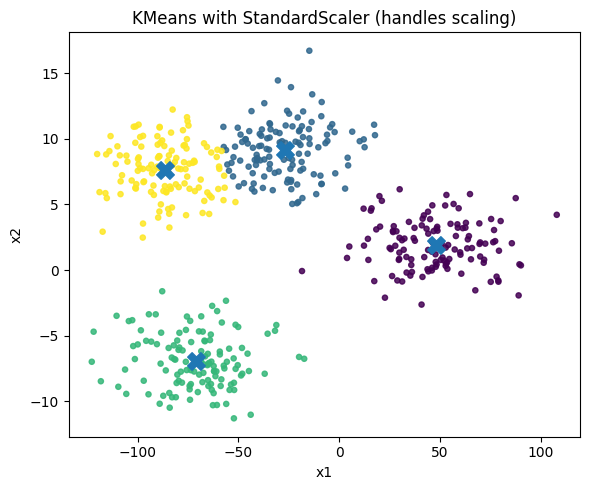

In [24]:

X_scaled_issue = X_blobs.copy()
X_scaled_issue[:,0] *= 10.0

km_raw = KMeans(n_clusters=4, init="k-means++", n_init=10, random_state=42).fit(X_scaled_issue)
decision_regions(km_raw, X_scaled_issue, "KMeans on unscaled (x1 stretched ×10)")

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), KMeans(n_clusters=4, init="k-means++", n_init=10, random_state=42))
pipe.fit(X_scaled_issue)
labels = pipe.named_steps["kmeans"].labels_
centers_std = pipe.named_steps["kmeans"].cluster_centers_
centers = pipe.named_steps["standardscaler"].inverse_transform(centers_std)

plt.figure(figsize=(6,5))
plt.scatter(X_scaled_issue[:,0], X_scaled_issue[:,1], c=labels, s=14, alpha=0.85)
plt.scatter(centers[:,0], centers[:,1], s=160, marker="X")
plt.title("KMeans with StandardScaler (handles scaling)")
plt.xlabel("x1"); plt.ylabel("x2"); plt.tight_layout(); plt.show()


## 8) Anisotropic blobs (rotated)

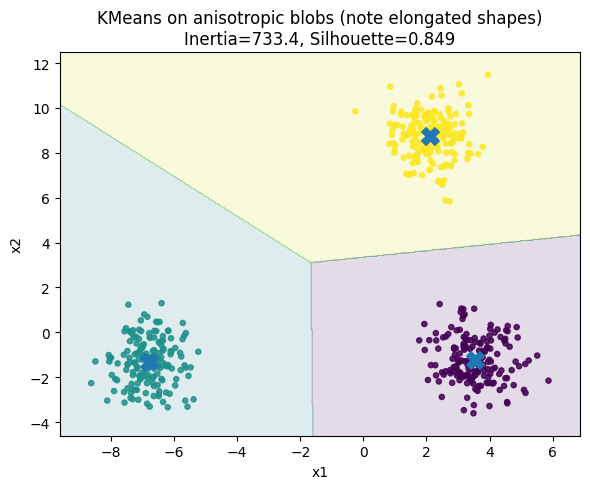

Silhouette (anisotropic blobs)
Mean silhouette = 0.849


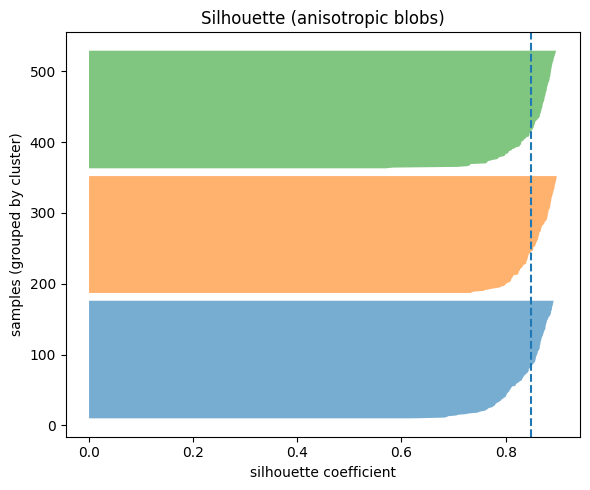

In [ ]:

X_aniso, y_aniso = make_blobs(n_samples=500, centers=3, random_state=42)
transformation = np.array([[0.6, -0.6], [0.4, 0.8]])
X_aniso = X_aniso @ transformation

km_aniso = KMeans(n_clusters=3, init="k-means++", n_init=20, random_state=42).fit(X_aniso)
decision_regions(km_aniso, X_aniso, "KMeans on anisotropic blobs (note elongated shapes)")
silhouette_diagram(X_aniso, km_aniso.labels_, "Silhouette (anisotropic blobs)")


## 9) Non-globular shapes (two moons) — KMeans limitations

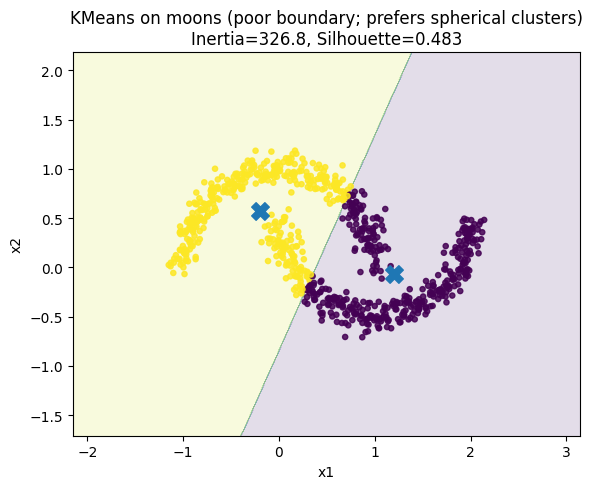

Silhouette (moons with KMeans)
Mean silhouette = 0.483


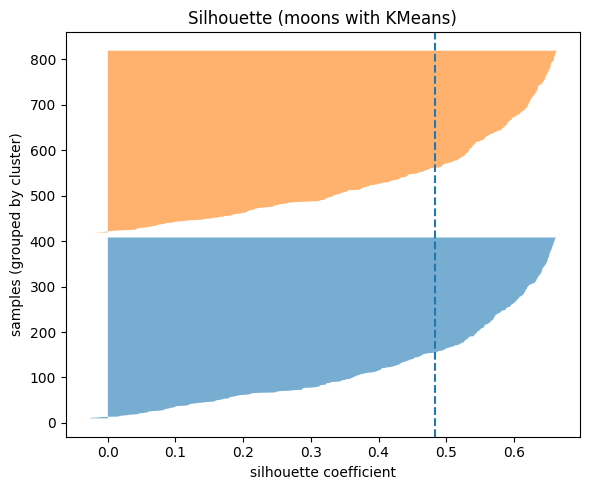

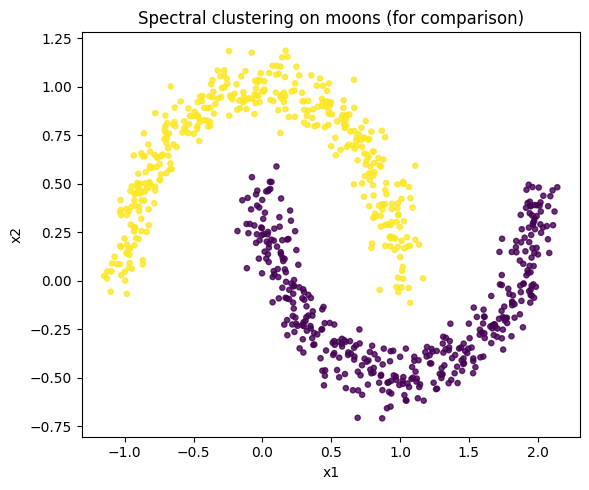

In [26]:

from sklearn.cluster import SpectralClustering

X_moons, _ = make_moons(n_samples=800, noise=0.08, random_state=42)

km_moons = KMeans(n_clusters=2, init="k-means++", n_init=20, random_state=42).fit(X_moons)
decision_regions(km_moons, X_moons, "KMeans on moons (poor boundary; prefers spherical clusters)")
silhouette_diagram(X_moons, km_moons.labels_, "Silhouette (moons with KMeans)")

spec = SpectralClustering(n_clusters=2, affinity="nearest_neighbors", assign_labels="kmeans", random_state=42)
labels_spec = spec.fit_predict(X_moons)
plot_clusters(X_moons, labels_spec, title="Spectral clustering on moons (for comparison)")
